<a href="https://colab.research.google.com/github/p-ai-org/p-sync/blob/main/Intro_to_Reservoir_Computing%2C_Distilled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Includes code from https://github.com/TUD-STKS/PyRCN/blob/master/examples/stock-price-prediction.ipynb and:
```
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data in "plain" scientific Python.
from https://mantas.info/code/simple_esn/
(c) 2012-2020 Mantas Lukoševičius
Distributed under MIT license https://opensource.org/licenses/MIT
```

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

!pip install easyesn
from easyesn import PredictionESN

Using Numpy backend.


### Helper Functions

In [ ]:
def rolling_window(a, window): # function from https://rigtorp.se/2011/01/01/rolling-statistics-numpy.html
  shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
  strides = a.strides + (a.strides[-1],)
  return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
def rolling_rms(a, window):
  return np.sqrt(np.mean(rolling_window(a, window)**2, axis=1))

from math import floor, ceil
def visualize_results(data, predicted, stepwise_prediction=True, step_size=1):
  sse = sum( np.square( data[trainLen+1:trainLen+errorLen+1] - 
    predicted[0:errorLen] ) )
  # ssto = sum( np.square( data[trainLen+1:trainLen+errorLen+1] - 
  #     np.mean(data[trainLen+1:trainLen+errorLen+1]) ) )
  # adjRSq = 1 - (sse/(errorLen-inSize))/(ssto/(errorLen-1))
  mse = sse/errorLen

  plt.figure(1).clear()
  plt.plot( range(trainLen+1, trainLen+errorLen+1), data[trainLen+1:trainLen+errorLen+1], 'g', alpha=0.5 )
  plt.plot( range(trainLen+1, trainLen+errorLen+1), predicted[0:errorLen], 'b', alpha=0.5 )
  plt.title('Sample of target and generated signals $y(n)$')
  plt.legend(['Target signal', 'Stepwise predicted signal'])
  # plt.figtext(.5, 0, 'Adjusted $R^2$ = ' + str( adjRSq )[:5], ha='center')
  plt.figtext(.5, 0, 'MSE = ' + str( mse )[:5], ha='center')
  
  error = predicted[0:errorLen] - data[trainLen+1:trainLen+errorLen+1]
  rms_win_len = min(len(error), 100)
  error_rms = rolling_rms(error, rms_win_len)

  fig = plt.figure(2)
  ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
  fig.suptitle('Error (raw and RMS)')
  ax1.plot( range(trainLen+1, trainLen+errorLen+1), error, 'r', label='Error (ideally 0)', alpha=0.5 )
  rms_support = range(trainLen+1+floor(rms_win_len / 2), trainLen+errorLen+1-ceil(rms_win_len / 2)+1)
  ax2.plot( rms_support, error_rms, 'r', alpha=0.5 )
  if stepwise_prediction:
    stepShiftError = predicted[0:errorLen] - data[trainLen+1-step_size:trainLen+errorLen+1-step_size]
    stepShiftError_rms = rolling_rms(stepShiftError, rms_win_len)
    ax1.plot( range(trainLen+1, trainLen+errorLen+1), stepShiftError, 'y', label='Time-shifted error (ideally greater than error)', alpha=0.5 )
    ax2.plot( rms_support, stepShiftError_rms, 'y', alpha=0.5 )
    relativeError = stepShiftError_rms - error_rms
    ax3.plot( rms_support, relativeError, 'k', alpha=0.5 )
  ax1.legend()
  ax3.legend()
  fig.show()

  plt.figure(4).clear()
  plt.plot( range(trainLen+1, trainLen+testLen+1), data[trainLen+1:trainLen+testLen+1], 'g', alpha=0.5 )
  plt.plot( range(trainLen+1, trainLen+testLen+1), predicted, 'b', alpha=0.5 )
  plt.title('Target and generated signals $y(n)$')
  plt.legend(['Target signal', 'Stepwise predicted signal'])

  plt.figure(5).clear()
  plt.plot( range(0, trainLen+testLen+1), data[:trainLen+testLen+1], 'g', alpha=0.5 )
  plt.plot( range(trainLen+1, trainLen+testLen+1), predicted, 'b', alpha=0.5 )
  plt.title('Target and generated signals $y(n)$ starting at $n=0$')
  plt.legend(['Target signal', 'Stepwise predicted signal'])  

## Fetch real-world data

In [16]:
!if [ -d "p-sync" ]; then cd p-sync && git pull; else git clone --depth 1 https://github.com/p-ai-org/p-sync.git; fi

# Sample data from https://trends.google.com/trends/explore?date=all&geo=US&q=%2Fm%2F0n073,%2Fm%2F0cycc,%2Fm%2F078qz,%2Fm%2F01b_21
time_series = pd.read_csv("p-sync/GoogleTrendsSampleDataset.csv", comment=';')
time_series.head()

Already up to date.


,Month,Common cold: (United States),Influenza: (United States),Summer: (United States),Cough: (United States)
0,2004-01,6,8,18,4
1,2004-02,7,5,21,3
2,2004-03,6,4,27,4
3,2004-04,4,3,32,3
4,2004-05,5,3,40,3


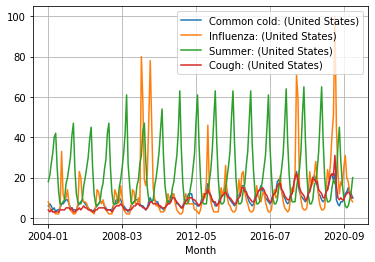

In [ ]:
time_series.plot(x='Month', legend=True, grid=True)
plt.show()

Pick one of the signals; normalize it into values between 0 and 1.

No handles with labels found to put in legend.


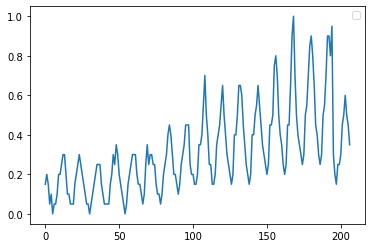

In [ ]:
trends = time_series['Common cold: (United States)'].to_numpy()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
trends = scaler.fit_transform(trends.reshape(-1, 1)).reshape(-1)

plt.plot(trends)
plt.legend()
plt.show()

Now we have a time-series dataset we can work with (a sequence of values). Let's split our data into train and validation sets.

In [ ]:
stepSize = 1

outputData = trends[stepSize:]
inputData = trends[:-stepSize]

trainLen = 150
testLen = 50

trainDataIn = inputData[:trainLen]
validationDataIn = inputData[trainLen:trainLen+testLen]

trainDataOut = outputData[:trainLen]
validationDataOut = outputData[trainLen:trainLen+testLen]

## One-step prediction

Now let's fit a model.



100% (117 of 117) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
No handles with labels found to put in legend.


0.041265480028610003


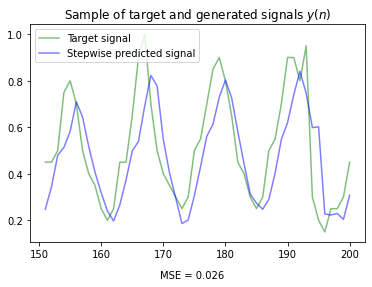

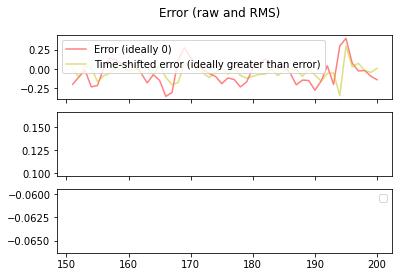

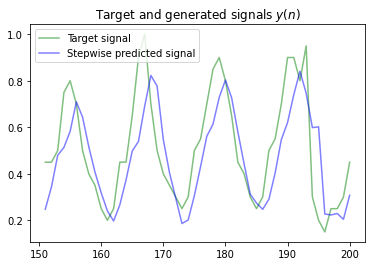

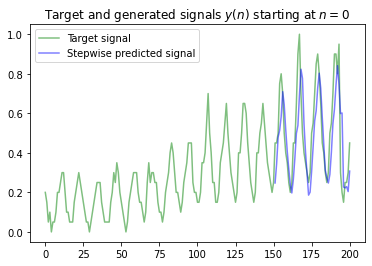

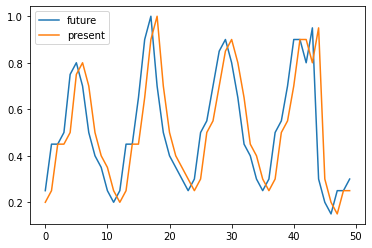

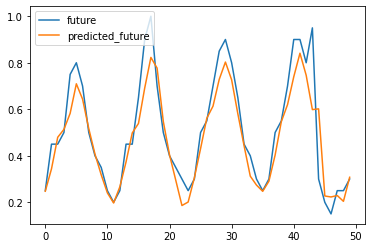

In [ ]:
np.random.seed(43)
esn = PredictionESN(n_input=1, n_output=1,
                    n_reservoir=100, # size of reservoir (number of nodes)
                    leakingRate=0.9, # when a node receives a signal, *how much of it* will it send to nodes it is connected to?
                                     # (the rest will be "absorbed" rather than exciting next node)
                    spectralRadius=1.0, # how far into the "future" can a signal echo? (i.e. when the reservoir is procedurally
                                        # generated at the beginning, how long of a path can a new connection be a shortcut for?)
                                        # also determines the time constant, i.e. how quickly signals decay in the reservoir
                    regressionParameters=[1e-2], # how much smoothing do we want the regression to use? (e.g. 1e-2 is smoothing more than 1e-8)
                    solver="lsqr") # solve for the output weights by minimizing least-squares 

trainError = esn.fit(trainDataIn, trainDataOut, transientTime="Auto", verbose=1)
print(trainError)
one_step_prediction = esn.predict(validationDataIn, verbose=1)

errorLen = testLen # used within visualize_results
visualize_results(outputData, one_step_prediction[:, 0], stepwise_prediction=True, step_size=stepSize)
plt.show()

plt.figure().clear()
plt.plot(validationDataOut, label="future")
plt.plot(validationDataIn, label="present")
plt.legend()
plt.show()

plt.plot(validationDataOut, label="future")
plt.plot(one_step_prediction, label="predicted_future")
plt.legend()
plt.show()